# __Temperature Forecasting__

## __1. Preparando o Ambiente__

In [278]:
# Bibliotecas para manipulção de dados
import numpy as np
import pandas as pd

# Bibliotecas para visualização
import matplotlib as m
import matplotlib.pyplot as plt
import seaborn as sns

# Statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose 

# Propeht
from prophet import Prophet

# Métricas
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


# Filtrando warings
import warnings
warnings.filterwarnings("ignore")

# Defifnindo Estilos
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.style.use('ggplot')


from matplotlib.pylab import rcParams 
rcParams['axes.titlepad'] = 20
rcParams["axes.titlesize"] = 20
rcParams['figure.figsize'] = 12,6


# Cores
CYAN = '#1696d2'
GREEN = '#55b748'
RED = '#db2b27'
YELLOW = '#fdbf11'

## __2. Análise de Dados__

### Carregando Dados

In [9]:
URL = "https://raw.githubusercontent.com/Colin-Riley/monitoring/main/temperature2.csv"

In [10]:
df = pd.read_csv(URL)
df.head()

,datetime,Miami
0,2012-10-01 12:00:00,NaN
1,2012-10-01 13:00:00,299.720000
2,2012-10-01 14:00:00,299.732518
3,2012-10-01 15:00:00,299.766579
4,2012-10-01 16:00:00,299.800641


### Definindo datetime como index

In [11]:
df["datetime"] = pd.to_datetime(df["datetime"])
df.set_index("datetime", inplace=True)
df.head()

,Miami
datetime,
2012-10-01 12:00:00,NaN
2012-10-01 13:00:00,299.720000
2012-10-01 14:00:00,299.732518
2012-10-01 15:00:00,299.766579
2012-10-01 16:00:00,299.800641


In [12]:
df.rename(columns={"Miami": "temperatura"}, inplace=True)

In [13]:
df.describe()

,temperatura
count,44448.000000
mean,34712.492683
std,95224.021759
min,275.233333
25%,296.440000
50%,299.389667
75%,302.069625
max,307002.000000


### __Visualizando Dados__

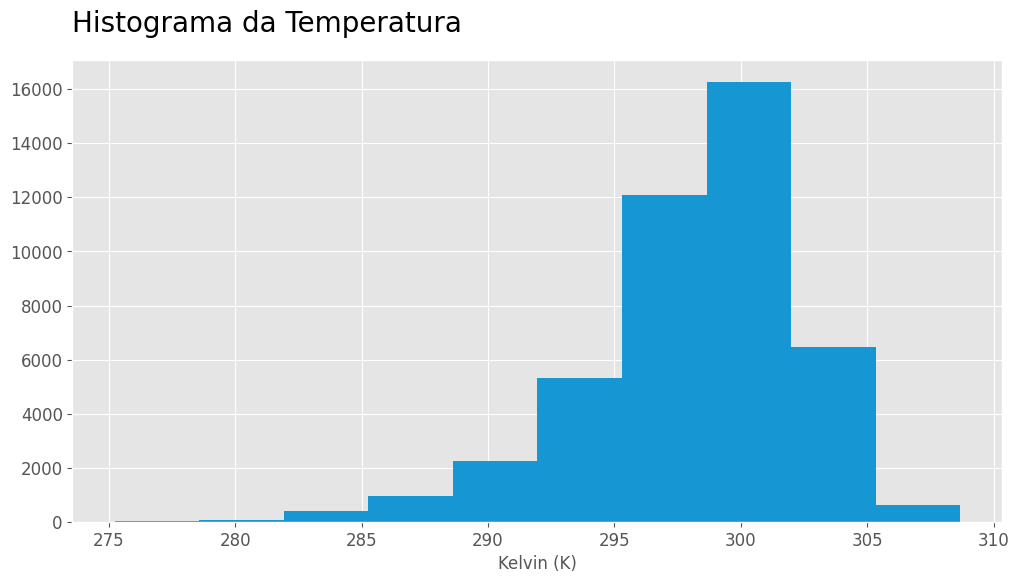

In [26]:
plt.hist(df["temperatura"], color=CYAN)
plt.title("Histograma da Temperatura", loc="left")
plt.xlabel("Kelvin (K)")
plt.show()

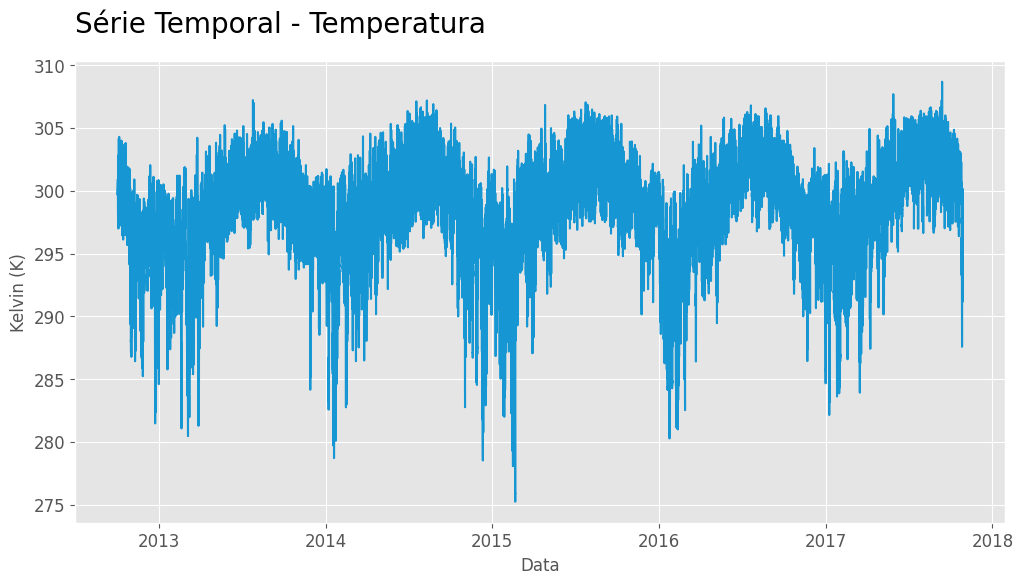

In [31]:
plt.plot(df.index, df.temperatura, color=CYAN)
plt.title("Série Temporal - Temperatura", loc="left")
plt.ylabel("Kelvin (K)")
plt.xlabel("Data")
plt.show()

### __Verificando possíveis valores mal formatados__

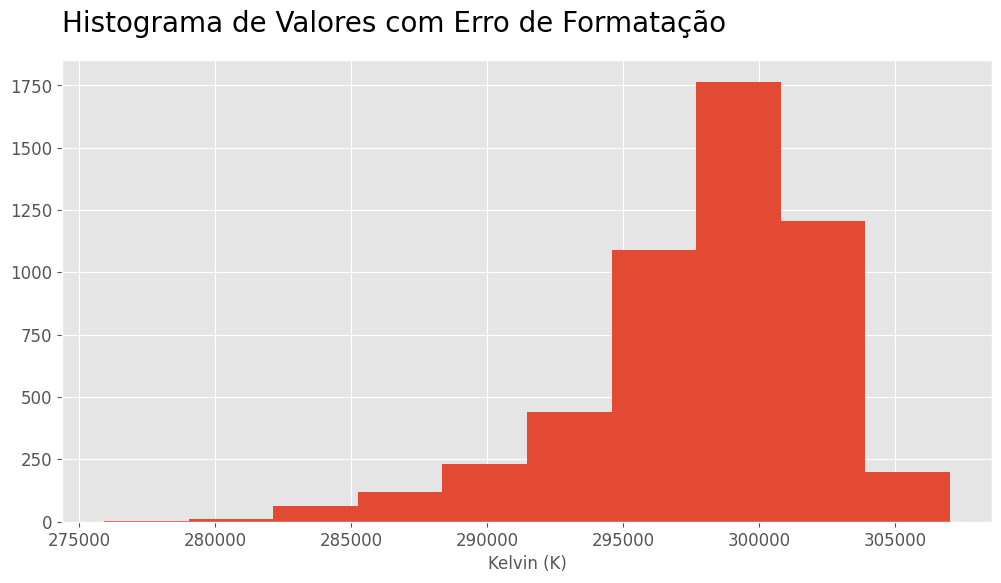

In [18]:
valores_mal_formatados = df[df.temperatura > 350]
plt.hist(valores_mal_formatados)
plt.title("Histograma de Valores com Erro de Formatação", loc="left")
plt.xlabel("Kelvin (K)")
plt.show()

In [9]:
# Valore
valores_mal_formatados[valores_mal_formatados.temperatura < 272000]

,temperatura
datetime,


#### __Corrigindo Dados__
Como os valores mal formatados estão em uma faixa entre **275000 e 305000** Kelvin, podemos fazer uma reescala dividindo por **1000**

In [19]:
def corrige_temperatura(temp):
    if temp > 350:
        if temp > 250000:
            return temp / 1000
        return np.NaN
    return temp

In [20]:
df["temperatura"] = df.temperatura.apply(corrige_temperatura)

In [21]:
df.describe()

,temperatura
count,44448.000000
mean,298.181274
std,4.190185
min,275.233333
25%,296.030000
50%,298.880000
75%,300.992375
max,308.680000


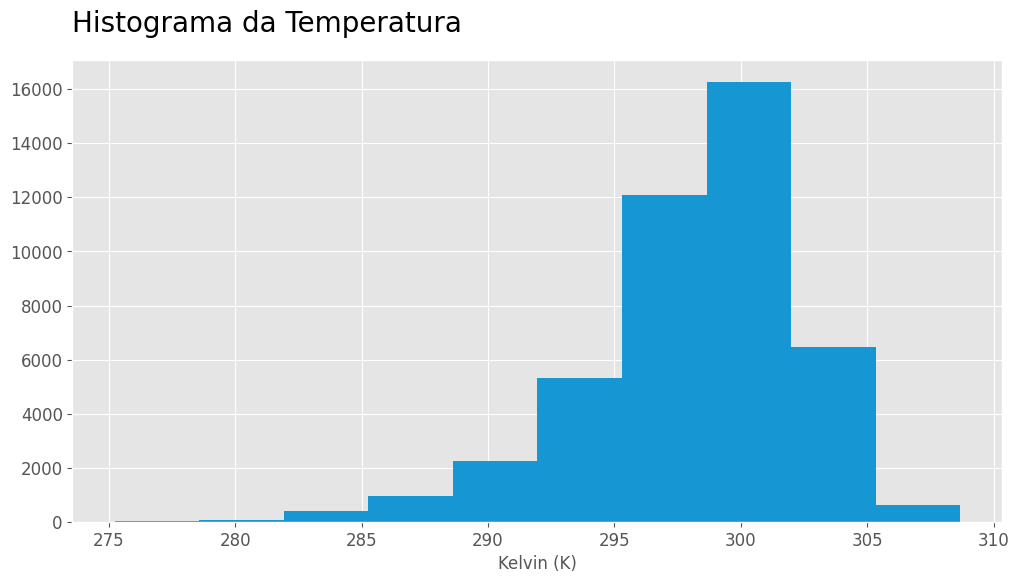

In [32]:
valores_mal_formatados = df[df.temperatura > 350]
plt.hist(df["temperatura"], color=CYAN)
plt.title("Histograma da Temperatura", loc="left")
plt.xlabel("Kelvin (K)")
plt.show()

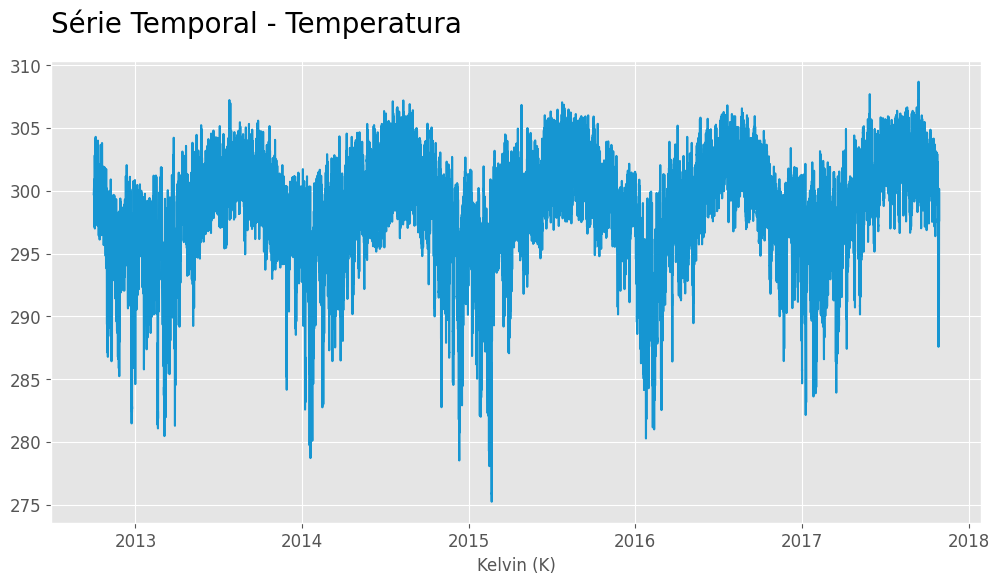

In [30]:
plt.plot(df["temperatura"], color=CYAN)
plt.title("Série Temporal - Temperatura", loc="left")
plt.xlabel("Kelvin (K)")
plt.show()

### __Corrigindo dados não válidos__

In [15]:
df.tail()

,temperatura
datetime,
2017-11-29 20:00:00,NaN
2017-11-29 21:00:00,NaN
2017-11-29 22:00:00,NaN
2017-11-29 23:00:00,NaN
2017-11-30 00:00:00,NaN


In [34]:
ultimo_valor_valido = df[~df.temperatura.isna()].index[-1]
ultimo_valor_valido

Timestamp('2017-10-28 00:00:00')

A partir do dia **28/10/2017** até o **dia 30/11/2017** não há valores válidos para a temperatura

In [35]:
df_clean = df.loc[:ultimo_valor_valido]

In [36]:
df_clean.tail()

,temperatura
datetime,
2017-10-27 20:00:00,299.92
2017-10-27 21:00:00,299.81
2017-10-27 22:00:00,299.15
2017-10-27 23:00:00,298.90
2017-10-28 00:00:00,297.64


In [37]:
df_clean.isna().sum()

temperatura    13
dtype: int64

#### __Imputação de dados com interpolação__

In [39]:
df_clean = df_clean.interpolate(method="time")

In [40]:
df_clean.isna().sum()

temperatura    1
dtype: int64

In [42]:
df_clean.head()

,temperatura
datetime,
2012-10-01 12:00:00,NaN
2012-10-01 13:00:00,299.720000
2012-10-01 14:00:00,299.732518
2012-10-01 15:00:00,299.766579
2012-10-01 16:00:00,299.800641


#### __Eliminando a primeira leitura de temperatura__

In [43]:
df_clean.dropna(inplace=True)

### __Criando coluna para represnetação da temperatura em graus Celsius__

In [44]:
df_clean["celsius"] = df_clean.temperatura - 273.15

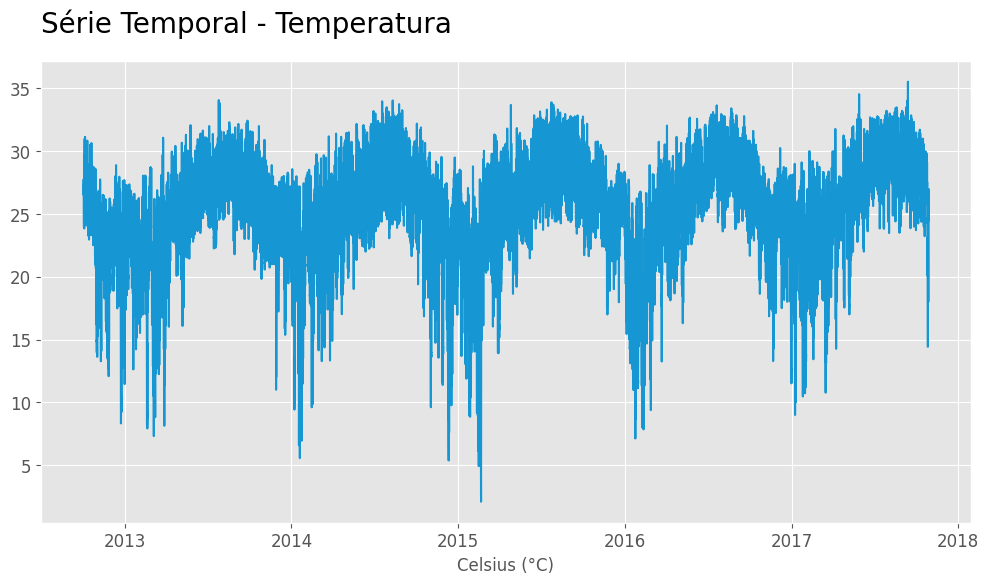

In [47]:
plt.plot(df_clean["celsius"], color=CYAN)
plt.title("Série Temporal - Temperatura", loc="left")
plt.xlabel("Celsius (°C)")
plt.show()

#### Média de temperatura por ano

In [59]:
media_anual = df_clean.groupby(df_clean.index.year).mean()["celsius"]
media_anual

datetime
2012    22.832328
2013    24.822875
2014    24.553171
2015    25.463788
2016    25.059253
2017    25.977980
Name: celsius, dtype: float64

In [97]:
media_anual = df_clean.groupby(df_clean.index.year).mean()["celsius"]
media_anual

datetime
2012    22.832328
2013    24.822875
2014    24.553171
2015    25.463788
2016    25.059253
2017    25.977980
Name: celsius, dtype: float64

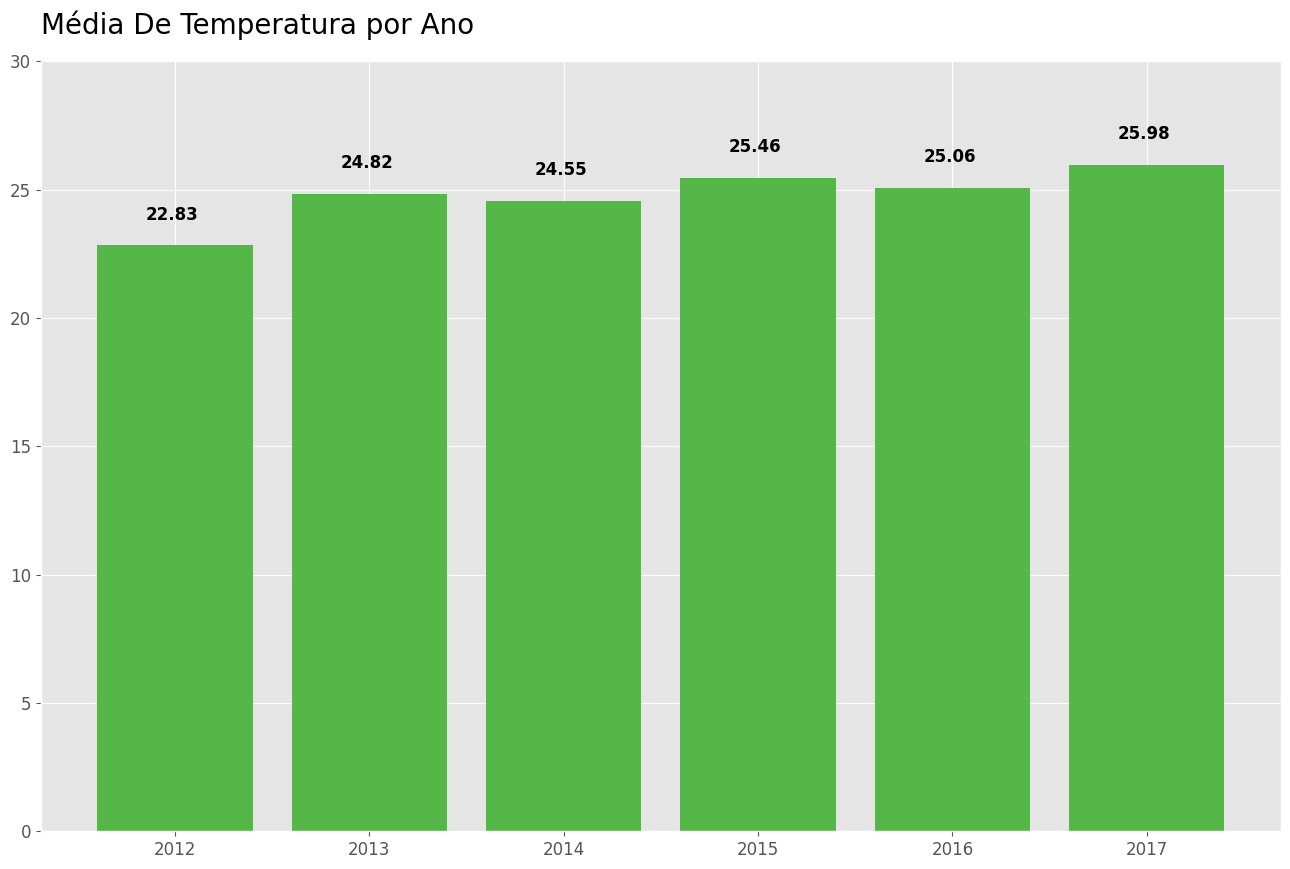

In [134]:
plt.bar(media_anual.index, media_anual.values, color=GREEN)
for index, value in zip(media_anual.index, media_anual.values):
    plt.text(index - 0.15, value + 1, str(f"{value:.2f}"), fontsize=12, fontweight="bold")
plt.title("Média De Temperatura por Ano", loc = "left")
plt.yticks(range(0, 35, 5))
plt.show()

In [101]:
media_mensal = df_clean.groupby(df_clean.index.month).mean()["celsius"]
media_mensal

datetime
1     20.758633
2     21.138263
3     22.368763
4     24.823567
5     26.206153
6     27.452639
7     28.437587
8     28.538811
9     27.787874
10    26.158497
11    23.301467
12    22.966277
Name: celsius, dtype: float64

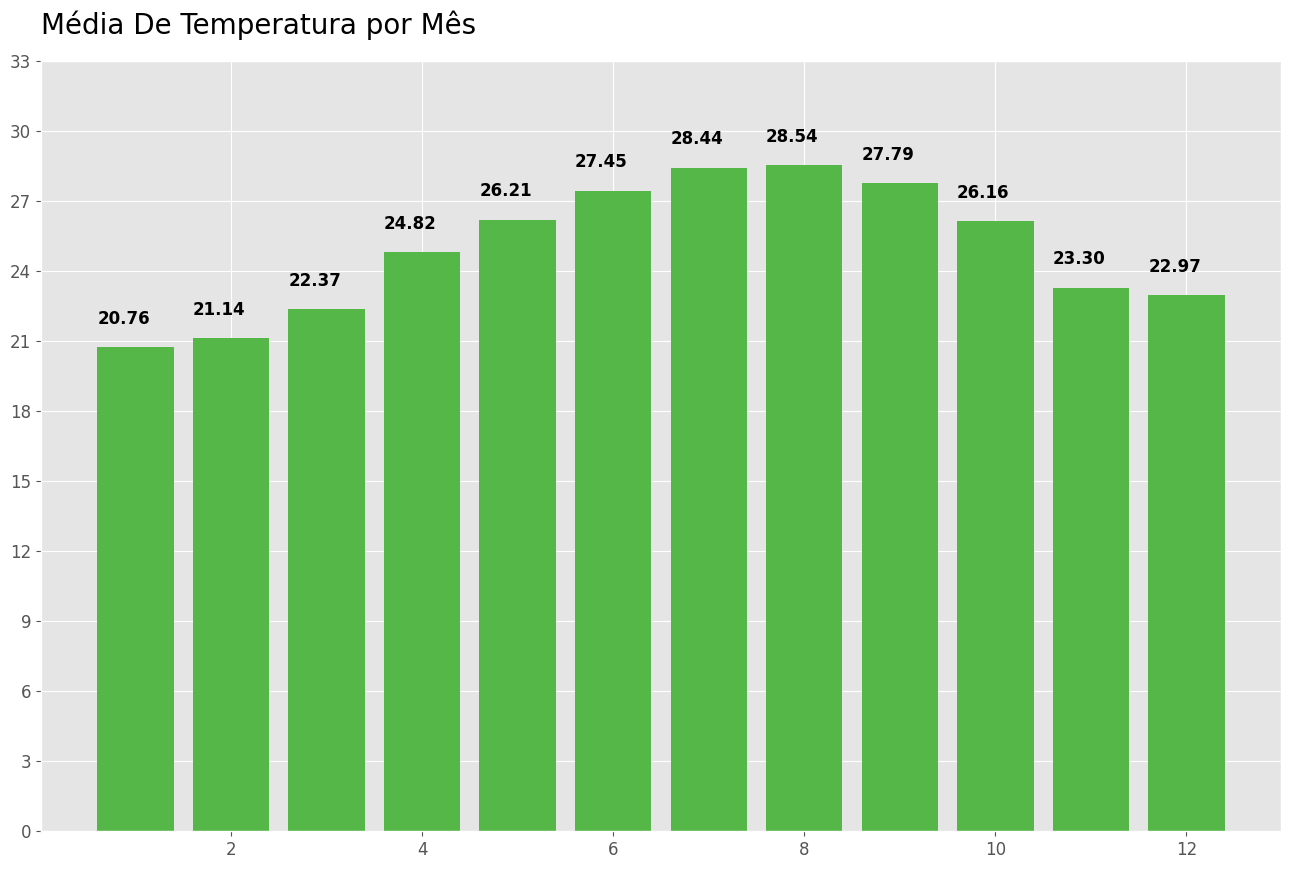

In [133]:
plt.bar(media_mensal.index, media_mensal.values, color=GREEN)
for index, value in zip(media_mensal.index, media_mensal.values):
    plt.text(index - .40, value + 1, str(f"{value:.2f}"), fontsize=12, fontweight="bold")
plt.title("Média De Temperatura por Mês", loc = "left")
plt.yticks(range(0, 36, 3))
plt.xticks()
plt.show()

In [112]:
media_por_hora= df_clean.groupby(df_clean.index.hour).mean()["celsius"]
media_por_hora

datetime
0     25.420794
1     24.878316
2     24.402600
3     24.199451
4     23.805605
5     23.520262
6     23.327867
7     23.052986
8     22.845903
9     22.800910
10    22.586649
11    22.588321
12    23.371910
13    23.985727
14    25.365472
15    26.176267
16    27.209171
17    27.652828
18    27.706673
19    27.867248
20    27.713528
21    27.230047
22    26.902048
23    26.135876
Name: celsius, dtype: float64

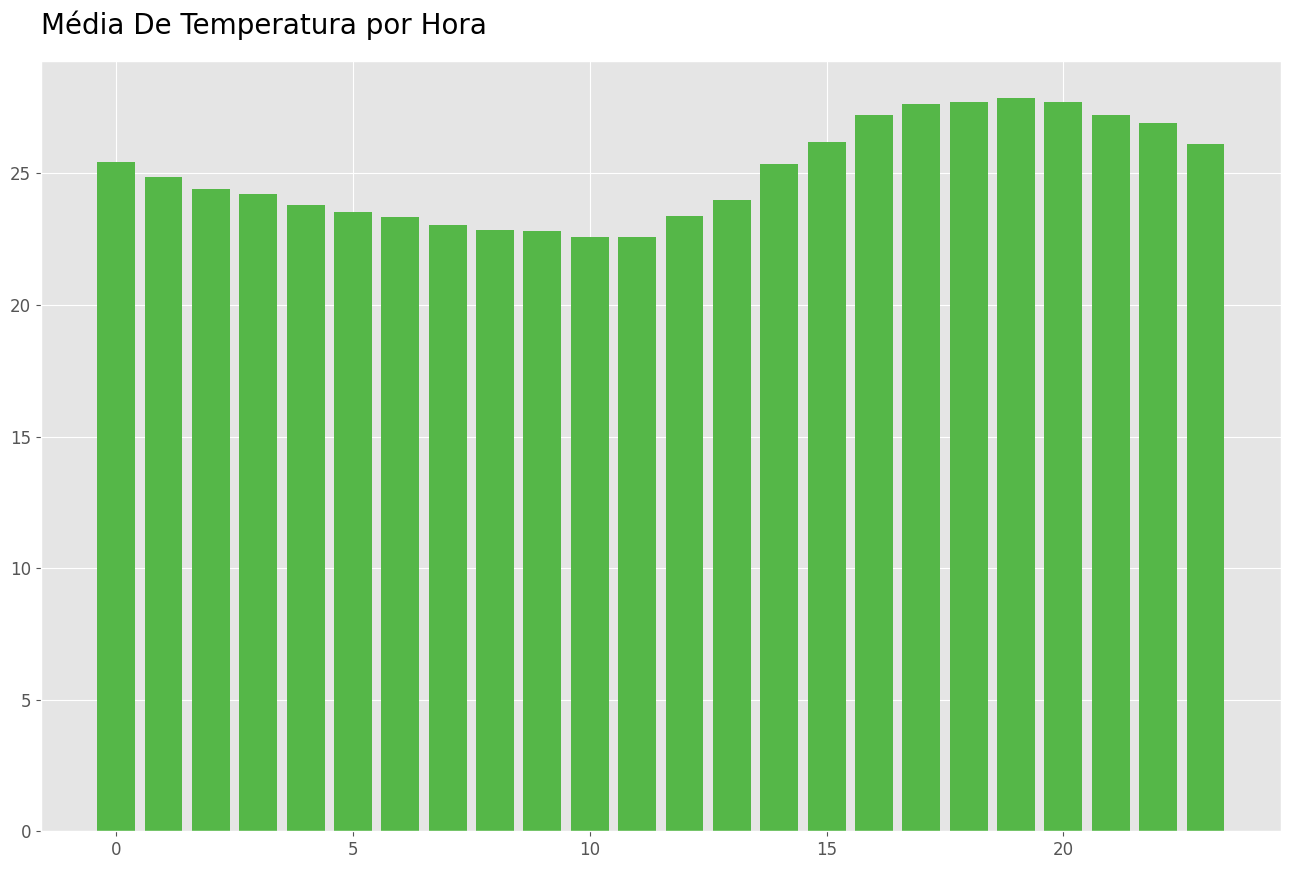

In [132]:
plt.bar(media_por_hora.index, media_por_hora.values, color=GREEN)
plt.title("Média De Temperatura por Hora", loc = "left")
plt.show()

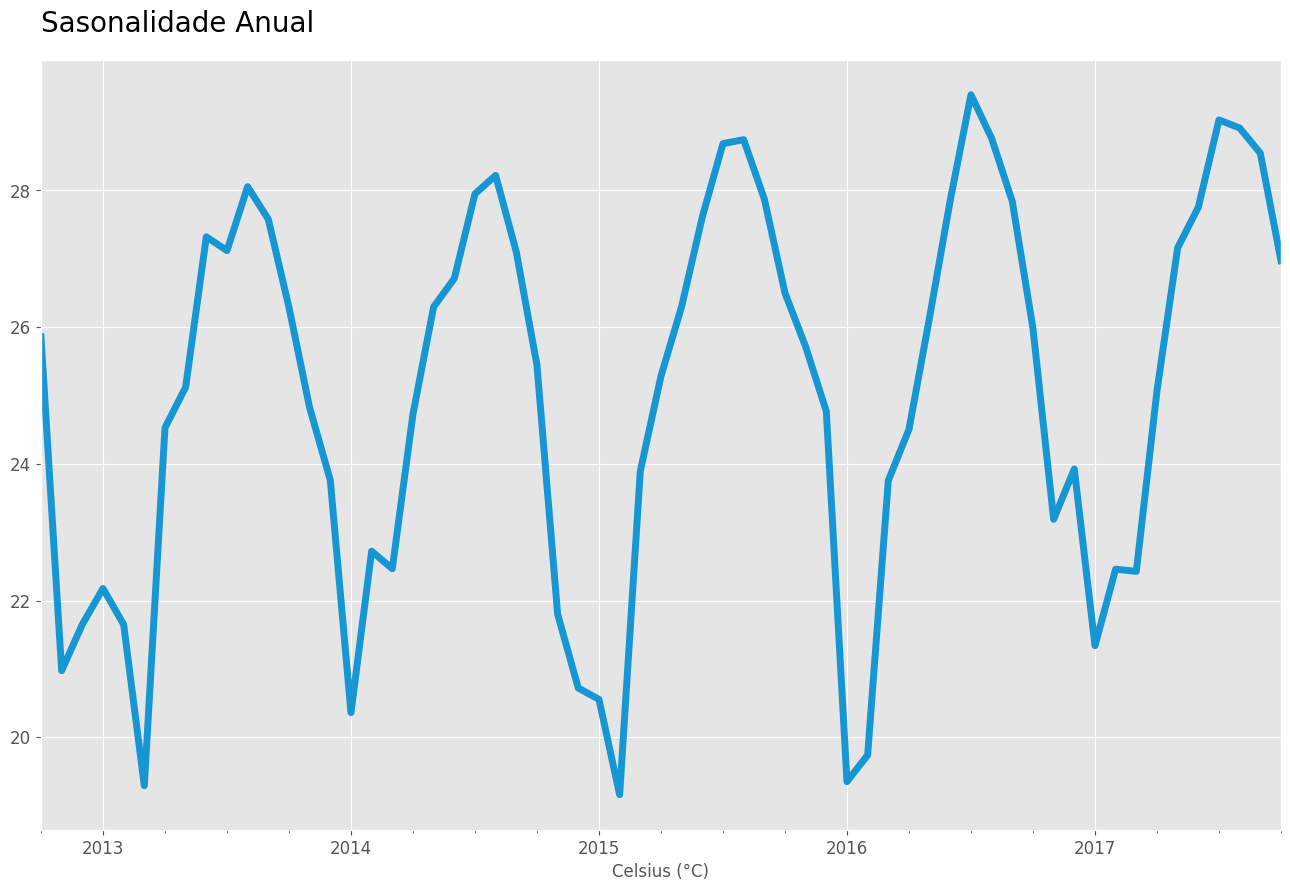

In [127]:
df_clean["celsius"].resample("M").mean().plot(linewidth=5, color=CYAN)
plt.title("Sasonalidade Anual", loc="left")
plt.xlabel("Celsius (°C)")
plt.show()

### __Decomposição Aditiva__

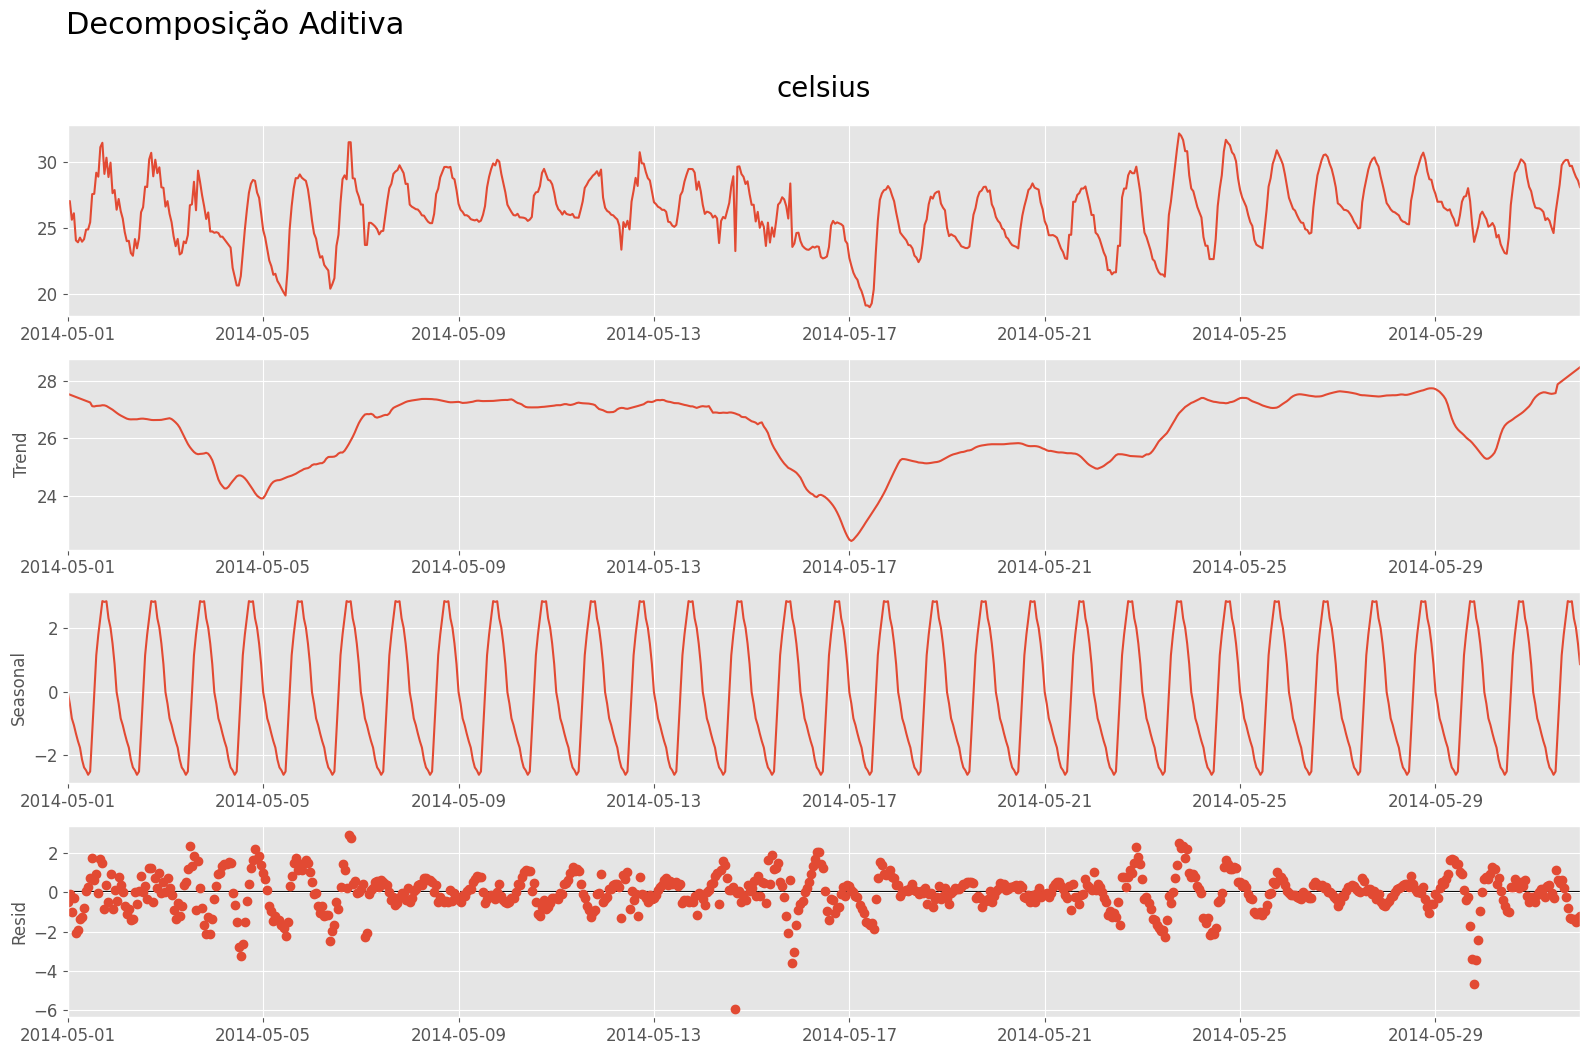

In [151]:
decomposicao_aditiva = seasonal_decompose(df_clean.celsius["2014-05"], model = 'aditive', 
                                                 extrapolate_trend = 'freq')
decomposicao_aditiva.plot().suptitle('Decomposição Aditiva', fontsize = 22, y=1.05, x=0.15)
plt.show()

### __Decomposição Multiplicativa__

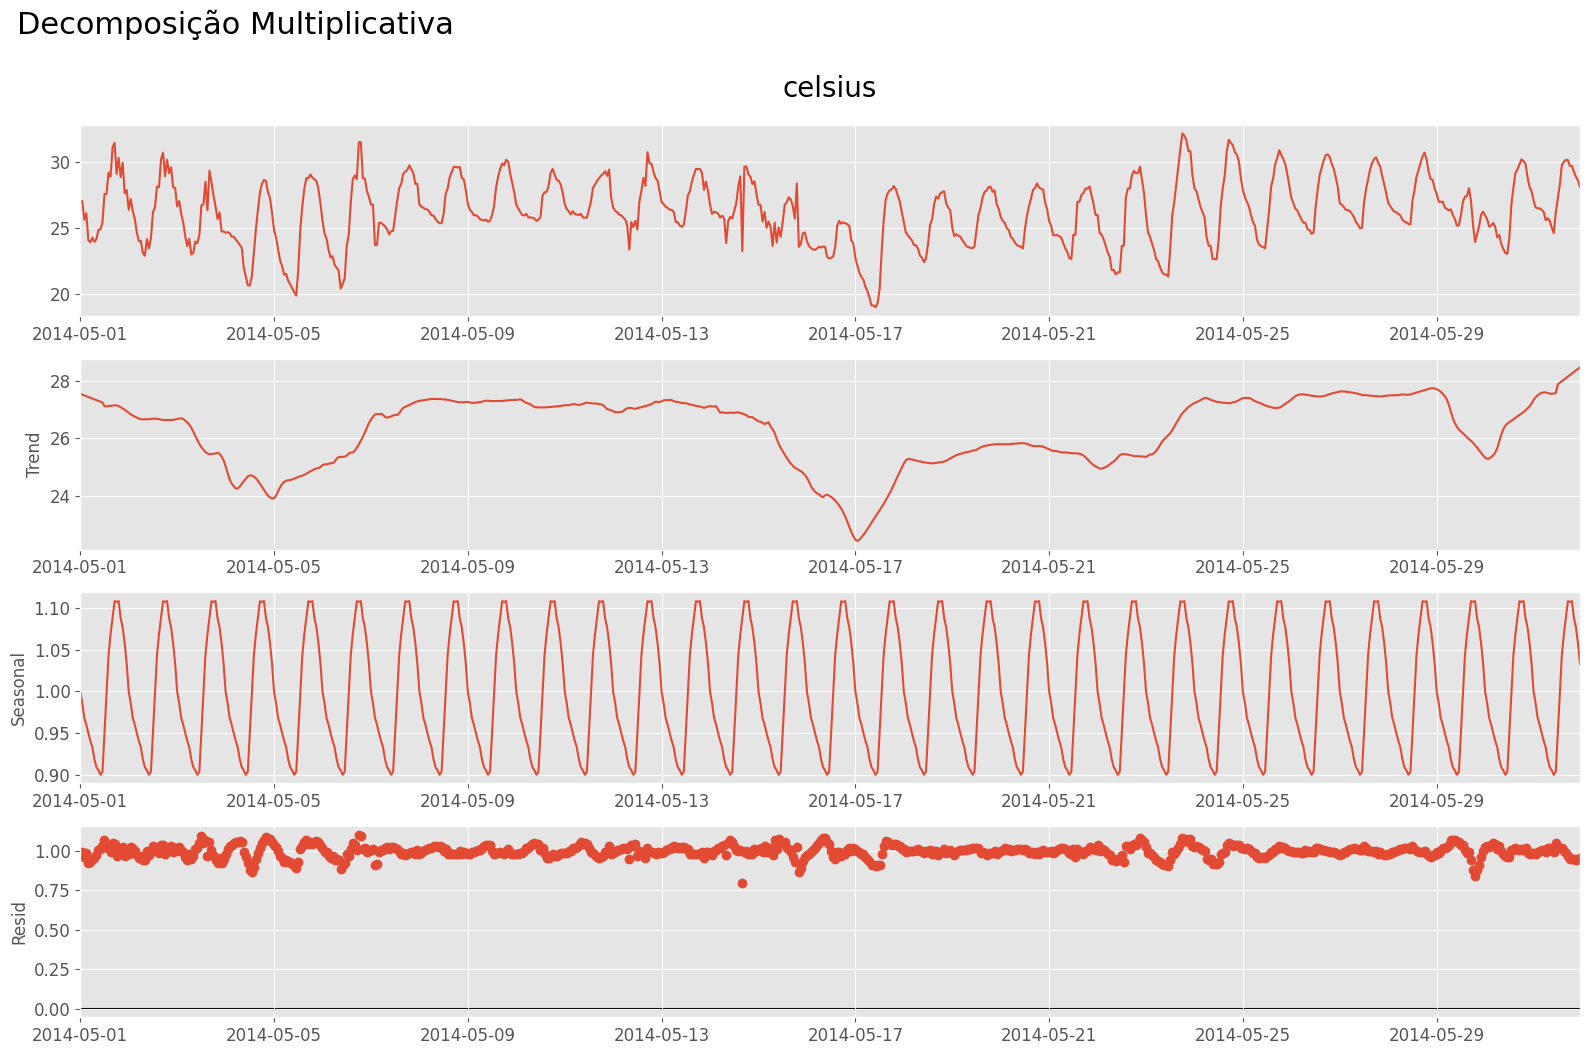

In [152]:
decomposicao_multiplicativa = seasonal_decompose(df_clean.celsius["2014-05"], model = 'multiplicative', 
                                                        extrapolate_trend = 'freq')
decomposicao_multiplicativa.plot().suptitle('Decomposição Multiplicativa', fontsize = 22, y=1.05, x=0.15)
plt.show()

## __3. Previsão__

### __Separando dados de Treino e Teste__

In [153]:
df_clean.index

DatetimeIndex(['2012-10-01 13:00:00', '2012-10-01 14:00:00',
               '2012-10-01 15:00:00', '2012-10-01 16:00:00',
               '2012-10-01 17:00:00', '2012-10-01 18:00:00',
               '2012-10-01 19:00:00', '2012-10-01 20:00:00',
               '2012-10-01 21:00:00', '2012-10-01 22:00:00',
               ...
               '2017-10-27 15:00:00', '2017-10-27 16:00:00',
               '2017-10-27 17:00:00', '2017-10-27 18:00:00',
               '2017-10-27 19:00:00', '2017-10-27 20:00:00',
               '2017-10-27 21:00:00', '2017-10-27 22:00:00',
               '2017-10-27 23:00:00', '2017-10-28 00:00:00'],
              dtype='datetime64[ns]', name='datetime', length=44460, freq=None)

- #### Após a limpeza de dados, possuimos dados de **01/10/2012** até **28/10/2017**
- #### Utilizaremos o mês de **outubro de 2017** como teste para nossos modelos de previsão e, em seguida, tentaremos prever os dados do mês de **novembro de 2017**(dados inicialmente nulos no dataset)

In [157]:
df_clean.index.max()

Timestamp('2017-10-28 00:00:00')

In [158]:
df_train = df_clean[:'2017-09']
df_train.index.max()

Timestamp('2017-09-30 23:00:00')

In [159]:
df_test = df_clean['2017-10':]

In [160]:
df_test.index.min()

Timestamp('2017-10-01 00:00:00')

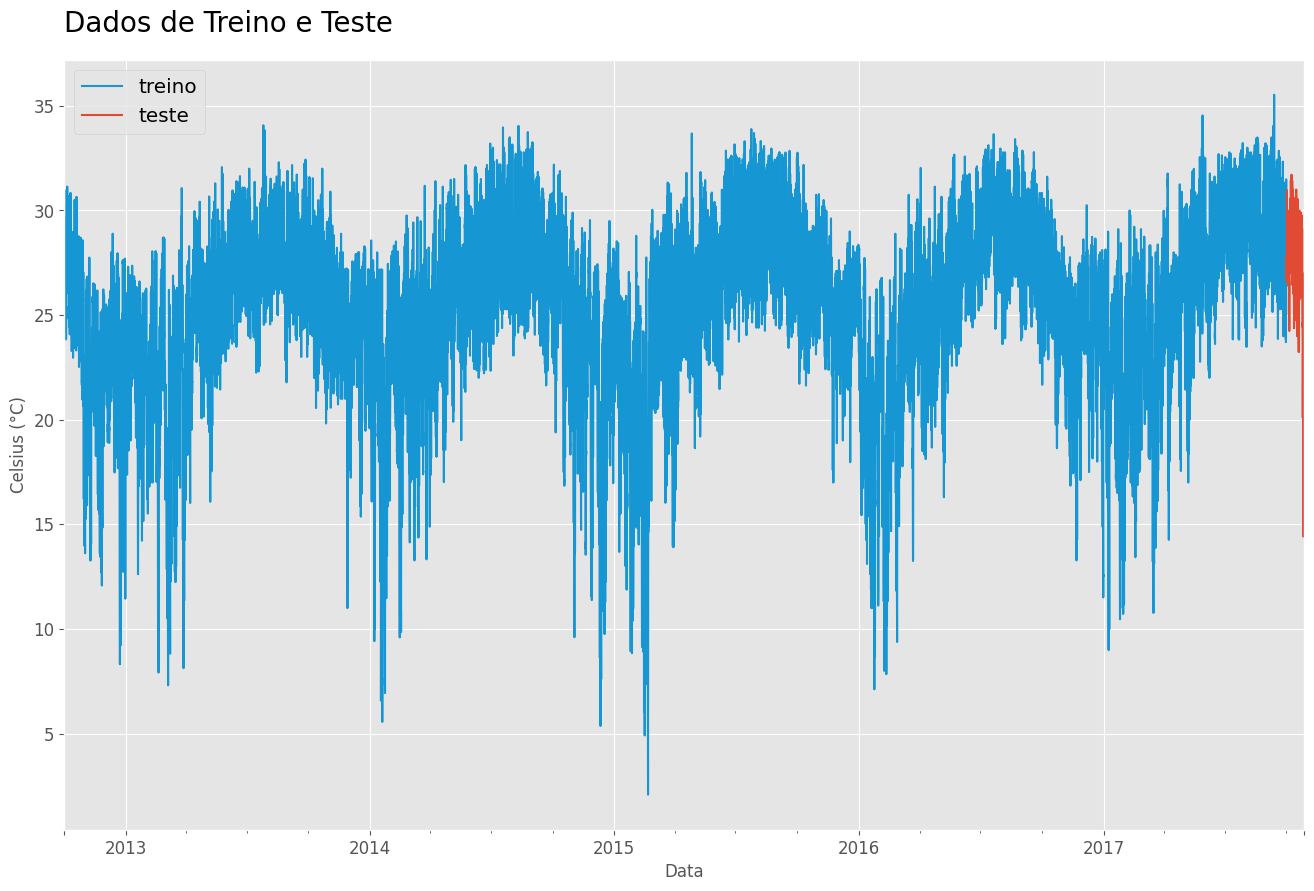

In [171]:
df_train["celsius"].plot(color=CYAN)
df_test["celsius"].plot()
plt.legend(labels=["treino", "teste"], loc="best", fontsize="x-large")
plt.title("Dados de Treino e Teste", loc="left")
plt.ylabel("Celsius (°C)")
plt.xlabel("Data")
plt.show()

### __Baseline__

- #### A média dos dados será utilizada como previsão base 

In [173]:
df_pred = df_test.copy()
df_pred.drop(columns=["temperatura", "celsius"], inplace=True)
df_pred["baseline"] = df_train["celsius"].mean()

In [174]:
df_pred.head()

,baseline
datetime,
2017-10-01 00:00:00,25.002769
2017-10-01 01:00:00,25.002769
2017-10-01 02:00:00,25.002769
2017-10-01 03:00:00,25.002769
2017-10-01 04:00:00,25.002769


In [190]:
def plot_previsao(pred):
    df_train["celsius"]["2017":].plot(color=CYAN)
    df_test["celsius"]["2017"].plot()
    df_pred[pred].plot(color="green", linewidth=2)
    plt.legend(labels=["treino", "teste", pred], loc="best", fontsize="x-large")
    plt.title(f"Previsão - {pred}", loc="left")
    plt.ylabel("Celsius (°C)")
    plt.xlabel("Data")
    plt.show()

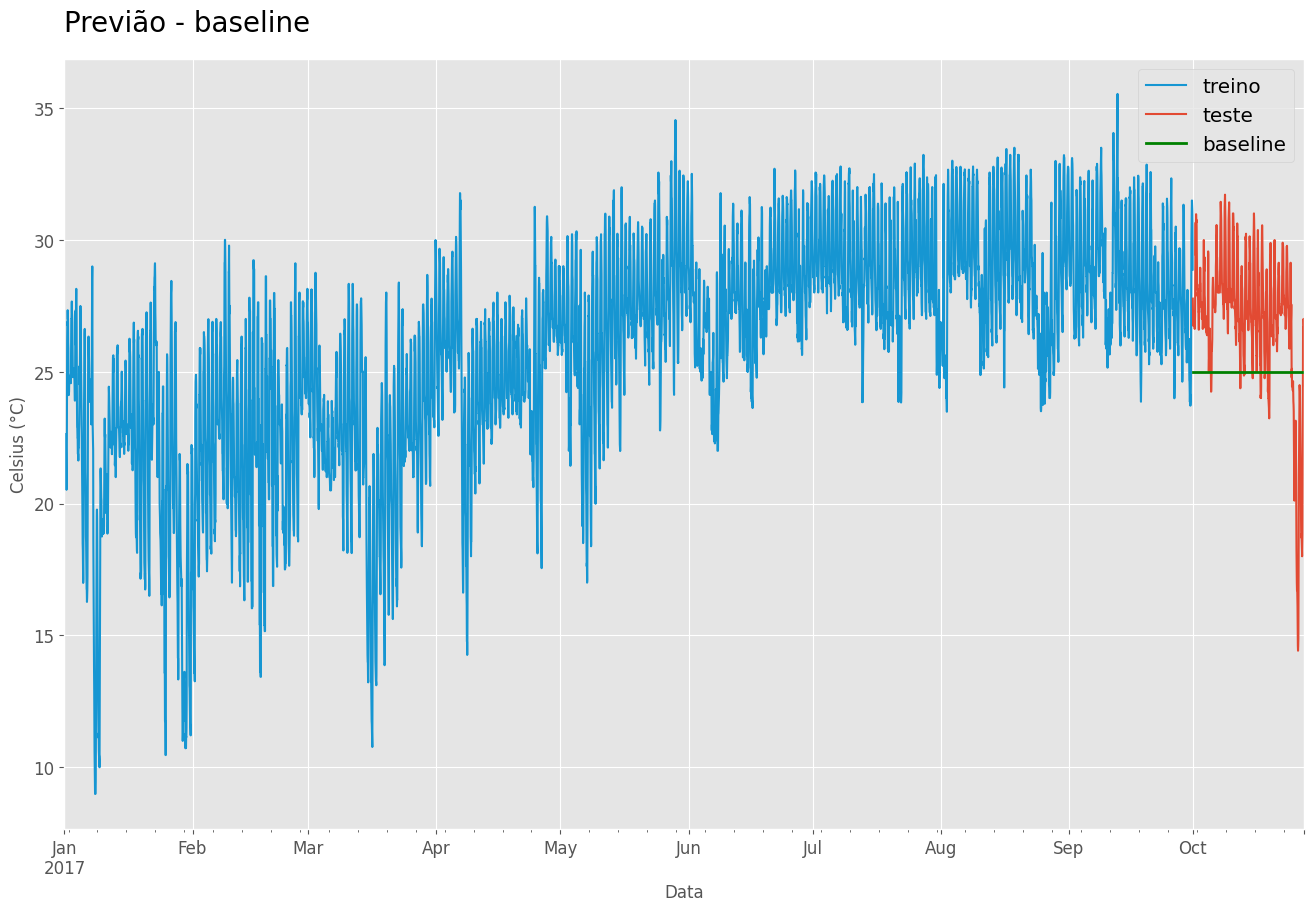

In [189]:
plot_previsao("baseline")

- #### Vamos utilizar a raíz do erro médio quadrático - RMSE e o erro médio absoluto percentual - MAPE  para comparar as previsões

In [191]:
rmse_baseline = mean_squared_error(df_test["celsius"].values, df_pred["baseline"].values, squared=False)
mape_baseline = mean_absolute_percentage_error(df_test["celsius"].values, df_pred["baseline"].values)

In [192]:
df_metrics = pd.DataFrame({"RMSE": [rmse_baseline], "MAE":[mape_baseline]}, index=["baseline"])

In [193]:
df_metrics

,RMSE,MAE
baseline,3.375403,0.109517


### __Modelo ARIMA__

#### __Plots de Autocorrelação__

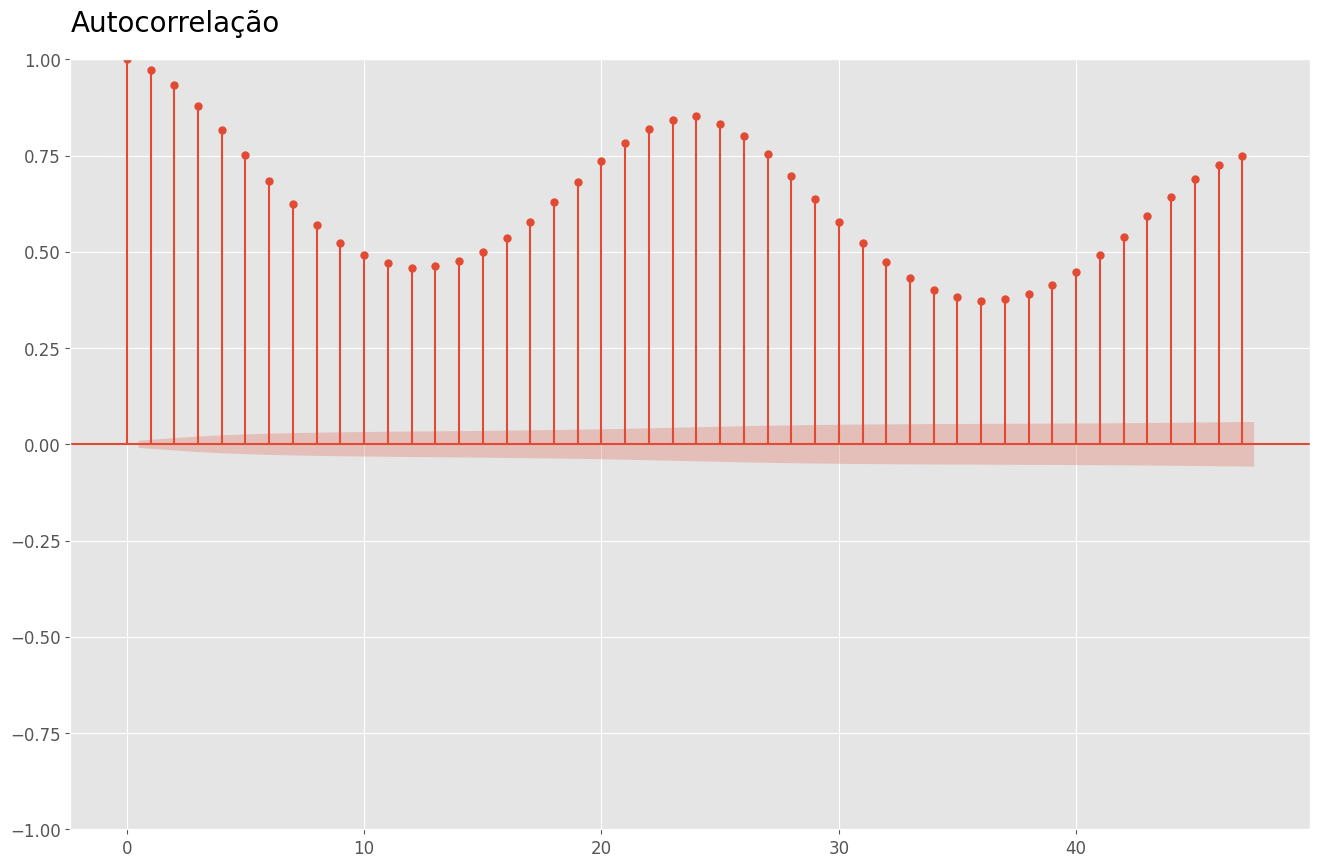

In [196]:
plot_acf(df_train.celsius, title="")
plt.title("Autocorrelação", loc="left")
plt.show()

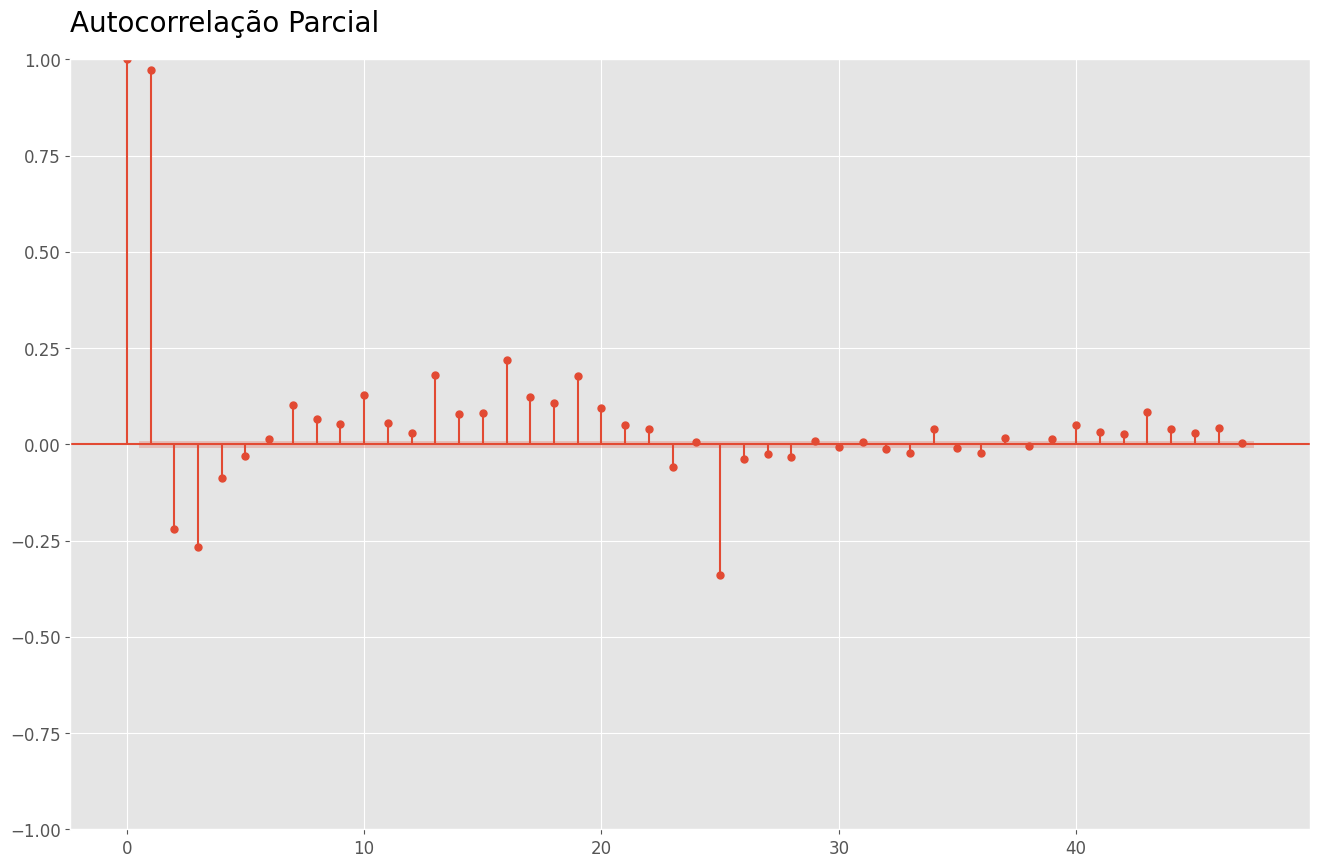

In [197]:
plot_pacf(df_train.celsius, title="")
plt.title("Autocorrelação Parcial", loc="left")
plt.show()

- #### Há grande dependência entre os lagas da funcção de autocorrelação, a difirenciação pode conter uma função com menor correlação entre os lags

#### __Autocorrelação da Série Após Diferenciação__

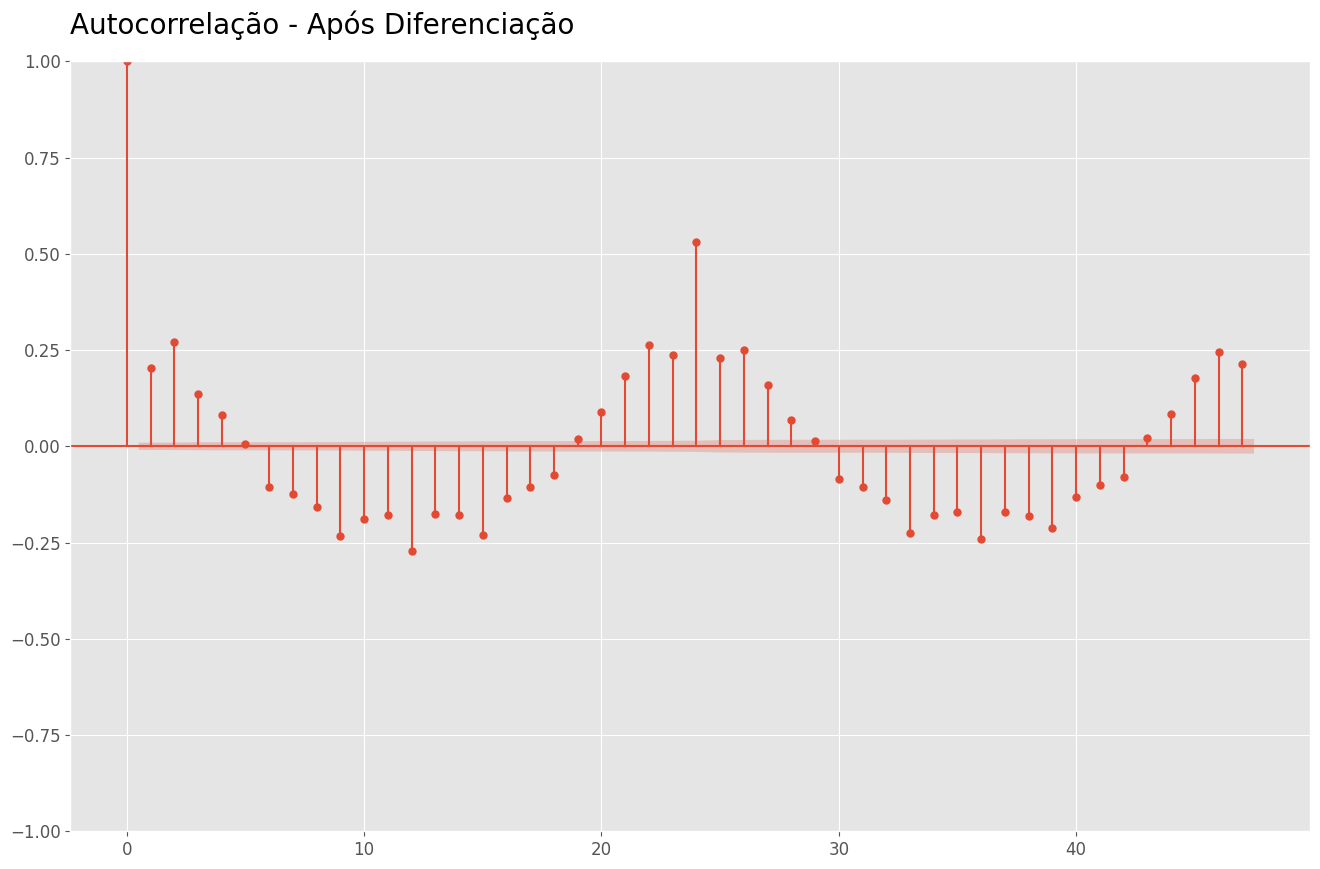

In [199]:
plot_acf(df_train.celsius.diff().dropna(), title="")
plt.title("Autocorrelação - Após Diferenciação", loc="left")
plt.show()

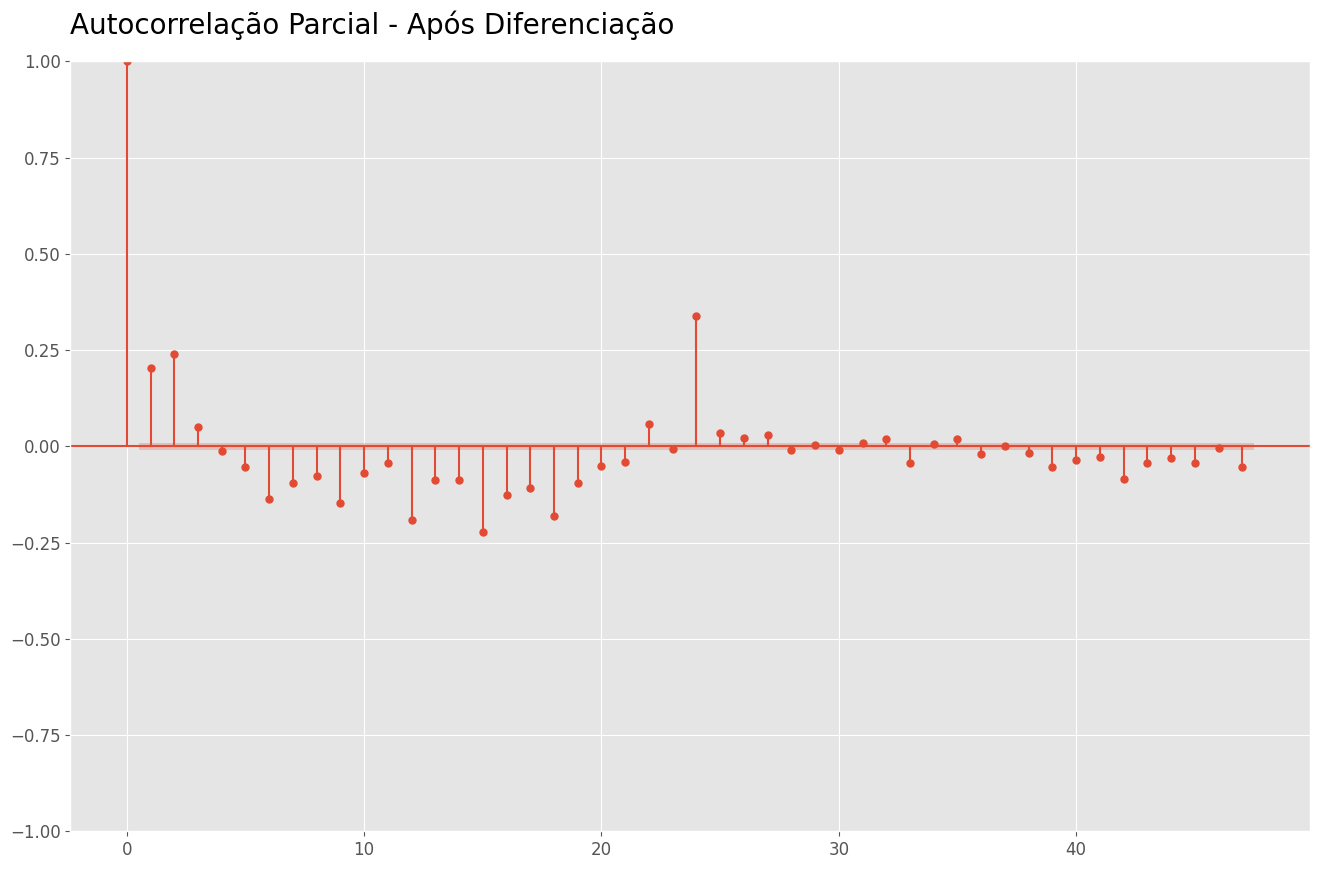

In [201]:
plot_pacf(df_train.celsius.diff().dropna(), title="")
plt.title("Autocorrelação Parcial - Após Diferenciação", loc="left")
plt.show()

#### __Selecionando Parâmetros do Modelo ARIMA(p, d, q)__

- **p = 2**
- **d = 1** 
- **q = 2**

In [202]:
modelo_arima_base = ARIMA(df_train.celsius, order = (2, 1, 2), freq = 'H')

In [203]:
modelo_v1 = modelo_arima_base.fit()  

In [204]:
dados_reais = df_train.celsius
previsoes = modelo_v1.fittedvalues

In [235]:
def plot_previsao_serie(dados_reais, previsoes, modelo):
    fig, ax = plt.subplots(2, 1)
    fig.tight_layout(pad=5.0)
    ax[0].plot(dados_reais, color=CYAN)
    ax[0].set_title("Série Original", loc="left")
    ax[1].plot(previsoes, color=GREEN)
    ax[1].set_title(f"Previsões - {modelo}", loc="left")
    plt.show()

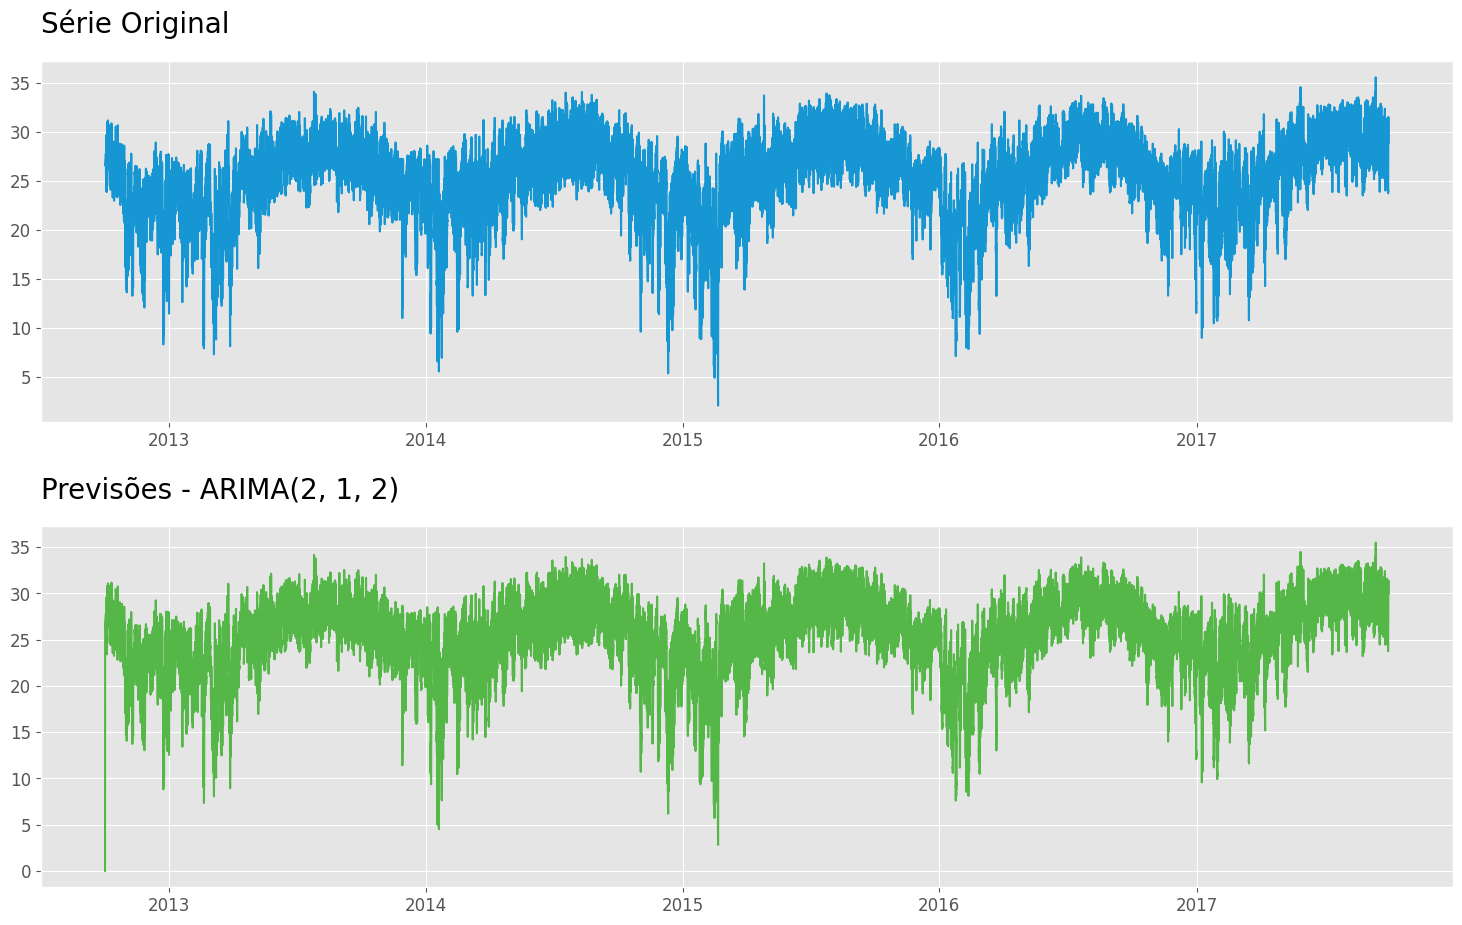

In [236]:
plot_previsao_serie(dados_reais, previsoes, "ARIMA(2, 1, 2)")

In [237]:
pred = modelo_v1.forecast(len(df_test.celsius), alpha = 0.05) 

In [238]:
df_pred["arima_v1"] = pred

In [239]:
df_pred.head()

,baseline,arima_v1
datetime,,
2017-10-01 00:00:00,25.002769,28.272067
2017-10-01 01:00:00,25.002769,27.665796
2017-10-01 02:00:00,25.002769,27.092040
2017-10-01 03:00:00,25.002769,26.589108
2017-10-01 04:00:00,25.002769,26.190203


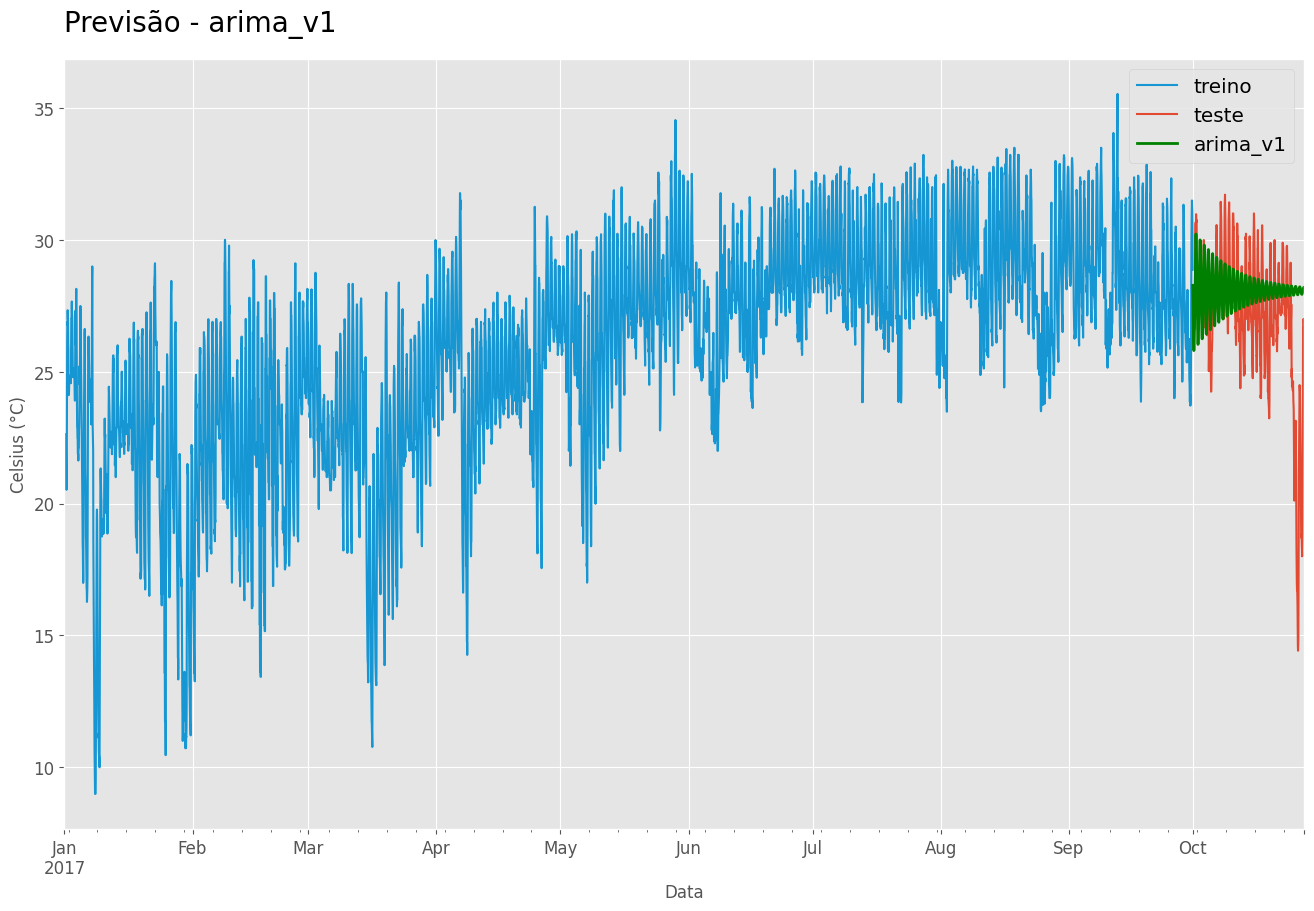

In [240]:
plot_previsao("arima_v1")

In [242]:
rmse_arima_1 = mean_squared_error(df_test["celsius"].values, df_pred["arima_v1"].values, squared=False)
mape_arima_1 = mean_absolute_percentage_error(df_test["celsius"].values, df_pred["arima_v1"].values)

In [243]:
df_metrics.loc["arima_v1"] = [rmse_arima_1, mape_arima_1]
df_metrics

,RMSE,MAE
baseline,3.375403,0.109517
arima_v1,2.839791,0.076272


### __Arima com Grid Search__

In [258]:
def avalia_modelo_arima(train, test, arima_order):
    
    model = ARIMA(train, order = arima_order, freq="H")
    model_fit = model.fit()
    predictions = model_fit.forecast(len(test))
        
    error = mean_squared_error(test, predictions, squared=False)
    return error

In [259]:
def avalia_melhor_arima(train, test, p_values, d_values, q_values):

    best_score, best_cfg = float("inf"), None
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                print(f"Ordem {order}")
                rmse = avalia_modelo_arima(train, test, order)
                if rmse < best_score:
                    best_score, best_cfg = rmse, order
                print(f"RMSE = {rmse:.4f}")

    print(f"\nMelhor Modelo ARIMA{best_cfg} RMSE = {best_score:.4f}")

In [260]:
p_values = [0, 1, 2]
q_values = [0, 1, 2]
d_values = [0, 1, 2]

In [261]:
avalia_melhor_arima(df_train.celsius, df_test.celsius, p_values, d_values, q_values)

Ordem (0, 0, 0)
RMSE = 3.3754
Ordem (0, 0, 1)
RMSE = 3.3741
Ordem (0, 0, 2)
RMSE = 3.3737
Ordem (0, 1, 0)
RMSE = 3.3331
Ordem (0, 1, 1)
RMSE = 3.2163
Ordem (0, 1, 2)
RMSE = 3.0108
Ordem (0, 2, 0)
RMSE = 609.2115
Ordem (0, 2, 1)
RMSE = 171.5965
Ordem (0, 2, 2)
RMSE = 249.6388
Ordem (1, 0, 0)
RMSE = 3.2570
Ordem (1, 0, 1)
RMSE = 3.2848
Ordem (1, 0, 2)
RMSE = 3.3132
Ordem (1, 1, 0)
RMSE = 3.1165
Ordem (1, 1, 1)
RMSE = 2.8082
Ordem (1, 1, 2)
RMSE = 2.7725
Ordem (1, 2, 0)
RMSE = 474.4786
Ordem (1, 2, 1)
RMSE = 264.1310
Ordem (1, 2, 2)
RMSE = 234.4357
Ordem (2, 0, 0)
RMSE = 3.3062
Ordem (2, 0, 1)
RMSE = 3.3675
Ordem (2, 0, 2)
RMSE = 3.3665
Ordem (2, 1, 0)
RMSE = 2.8060
Ordem (2, 1, 1)
RMSE = 2.7717
Ordem (2, 1, 2)
RMSE = 2.8398
Ordem (2, 2, 0)
RMSE = 403.7840
Ordem (2, 2, 1)
RMSE = 2.8101
Ordem (2, 2, 2)
RMSE = 2.7785

Melhor Modelo ARIMA(2, 1, 1) RMSE = 2.7717


In [262]:
modelo_arima_grid = ARIMA(df_train.celsius, order = (2, 1, 1), freq = 'H')

In [263]:
modelo_v2 = modelo_arima_grid.fit()  

In [264]:
dados_reais = df_train.celsius
previsoes = modelo_v2.fittedvalues

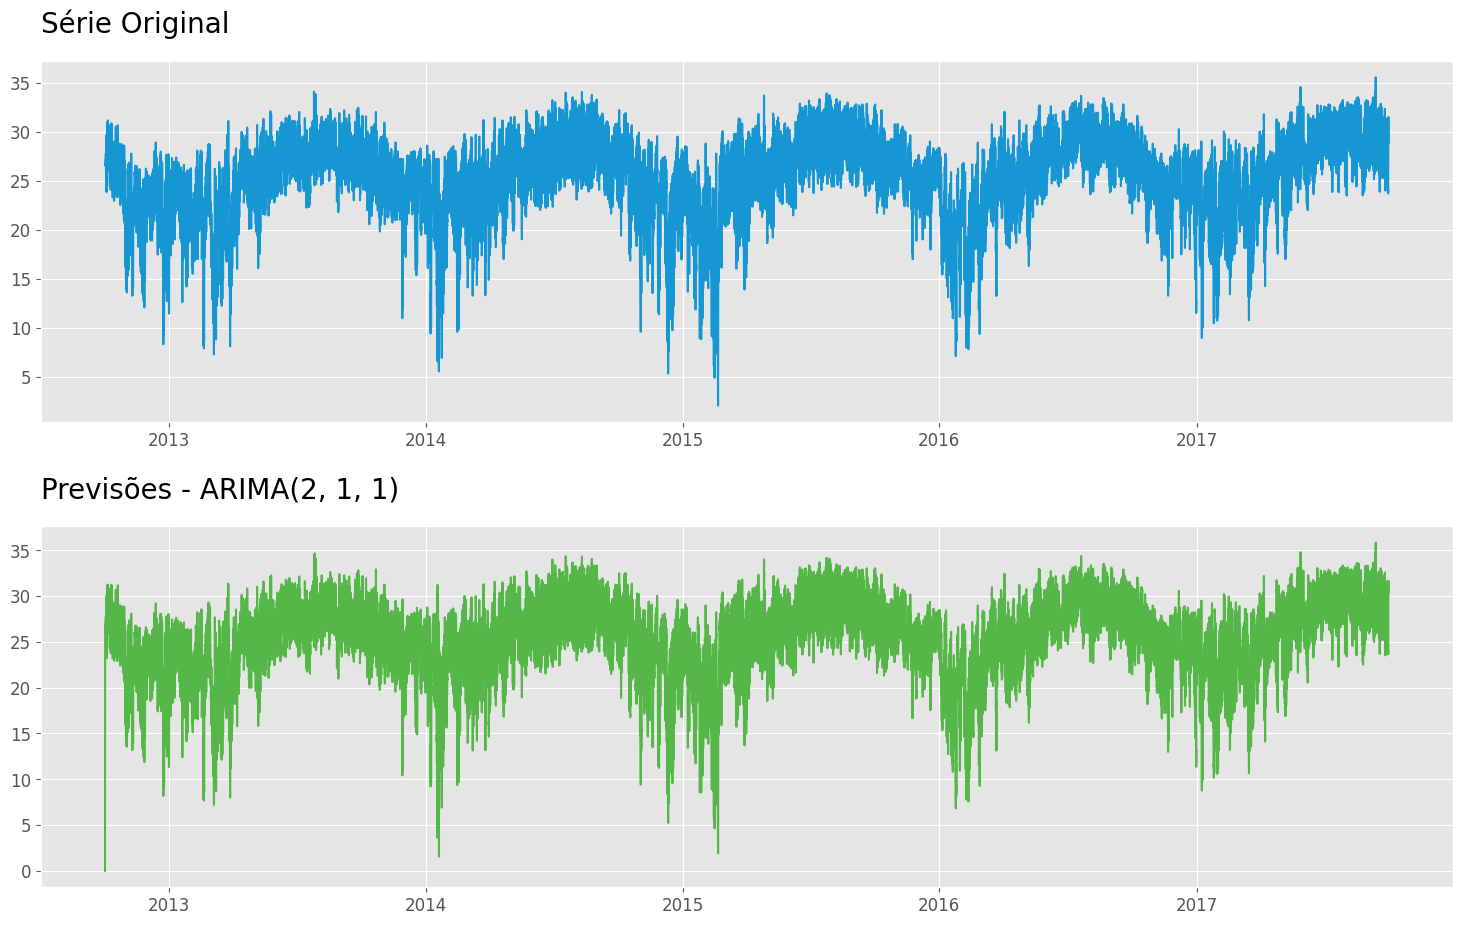

In [266]:
plot_previsao_serie(dados_reais, previsoes, "ARIMA(2, 1, 1)")

In [267]:
pred = modelo_v2.forecast(len(df_test.celsius), alpha = 0.05) 

In [268]:
df_pred["arima_v2"] = pred

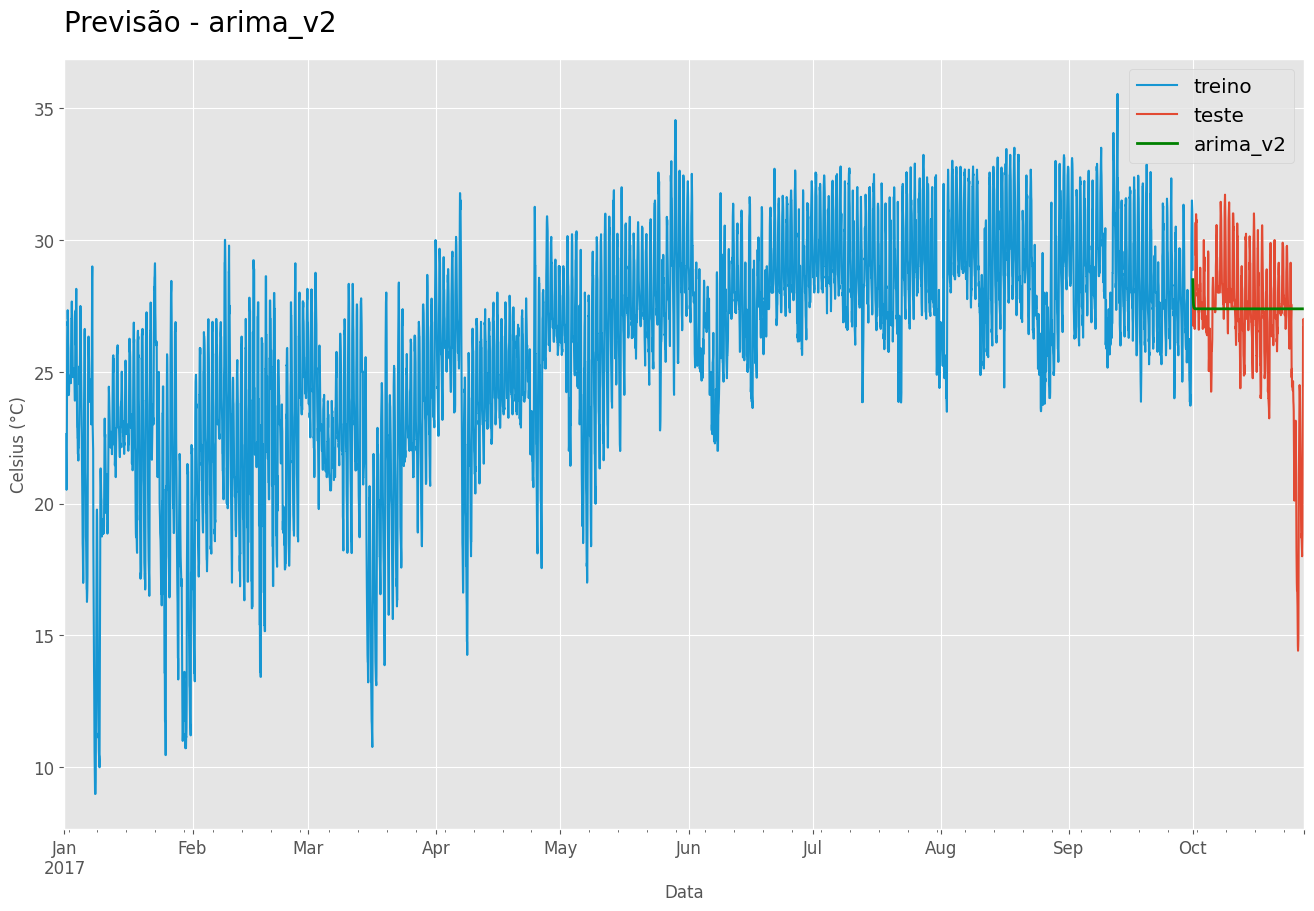

In [269]:
plot_previsao("arima_v2")

In [270]:
rmse_arima_grid = mean_squared_error(df_test["celsius"].values, df_pred["arima_v2"].values, squared=False)
mape_arima_grid = mean_absolute_percentage_error(df_test["celsius"].values, df_pred["arima_v2"].values)

In [271]:
df_metrics.loc["arima_v2"] = [rmse_arima_grid, mape_arima_grid]
df_metrics

,RMSE,MAE
baseline,3.375403,0.109517
arima_v1,2.839791,0.076272
arima_v2,2.771742,0.075565


### __Modelo Prophet__

In [279]:
modelo_prophet = Prophet(interval_width=0.95, daily_seasonality=True)

#### Dados de Treino e Teste 

In [280]:
df_prophet_train = df_train.celsius.to_frame()
df_prophet_train.reset_index(inplace=True)
df_prophet_train.rename(columns={"celsius":"y", "datetime":"ds"}, inplace=True)
df_prophet_train.head()

,ds,y
0,2012-10-01 13:00:00,26.570000
1,2012-10-01 14:00:00,26.582518
2,2012-10-01 15:00:00,26.616579
3,2012-10-01 16:00:00,26.650641
4,2012-10-01 17:00:00,26.684703


In [281]:
df_prophet_test = df_test.celsius.to_frame()
df_prophet_test.reset_index(inplace=True)
df_prophet_test.rename(columns={"celsius":"y", "datetime":"ds"}, inplace=True)
df_prophet_test.head()

,ds,y
0,2017-10-01 00:00:00,27.77
1,2017-10-01 01:00:00,27.12
2,2017-10-01 02:00:00,26.74
3,2017-10-01 03:00:00,27.11
4,2017-10-01 04:00:00,26.77


#### Treinando Modelo

In [282]:
modelo_prophet.fit(df_prophet_train)

20:58:55 - cmdstanpy - INFO - Chain [1] start processing
21:00:36 - cmdstanpy - INFO - Chain [1] done processing


#### Datasets para previsão

In [313]:
df_prophet_pred = modelo_prophet.make_future_dataframe(periods = len(df_test.celsius), freq = 'H')
df_prophet_pred.count()

ds    44460
dtype: int64

In [314]:
df_prophet_pred.tail()

,ds
44455,2017-10-27 20:00:00
44456,2017-10-27 21:00:00
44457,2017-10-27 22:00:00
44458,2017-10-27 23:00:00
44459,2017-10-28 00:00:00


In [315]:
df_prophet_test.tail()

,ds,y
644,2017-10-27 20:00:00,26.77
645,2017-10-27 21:00:00,26.66
646,2017-10-27 22:00:00,26.00
647,2017-10-27 23:00:00,25.75
648,2017-10-28 00:00:00,24.49


In [311]:
pred_prophet = modelo_prophet.predict(df_prophet_pred)

In [312]:
pred_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2012-10-01 13:00:00,25.735350,20.977766,30.573537
1,2012-10-01 14:00:00,26.876464,22.301728,31.661443
2,2012-10-01 15:00:00,27.975253,23.155356,32.543933
3,2012-10-01 16:00:00,28.799910,24.072777,33.657787
4,2012-10-01 17:00:00,29.276517,24.678172,34.377687


In [292]:
dados_reais = df_train.celsius
previsoes = pred_prophet["yhat"]

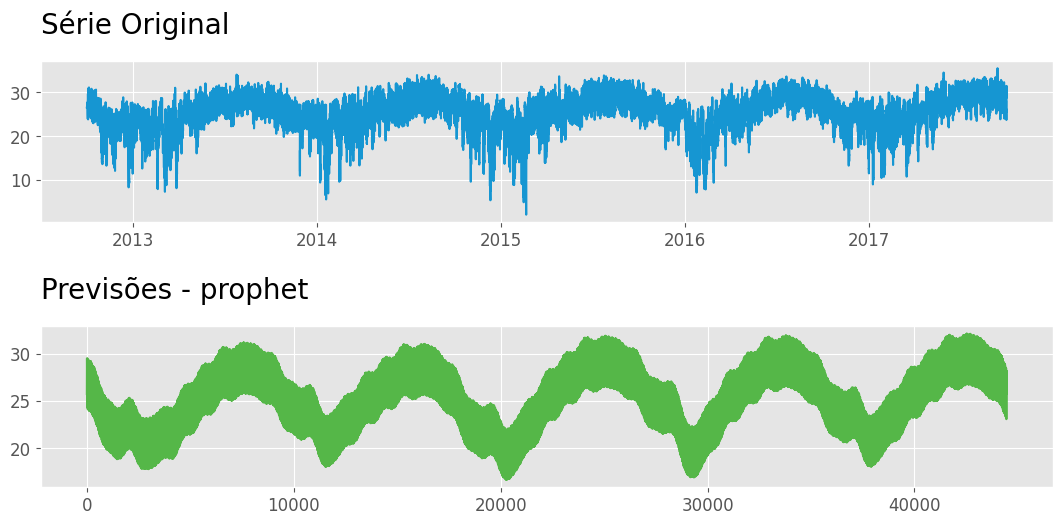

In [293]:
plot_previsao_serie(dados_reais, previsoes, "prophet")

In [294]:
df_pred["prophet"] = pred_prophet[pred_prophet["ds"]>="2017-10"]["yhat"].values

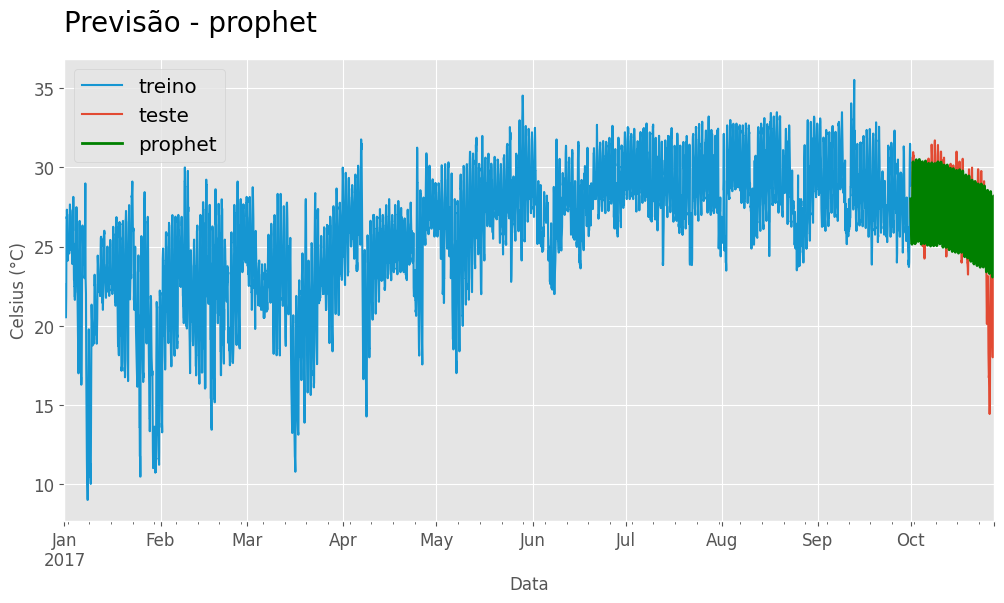

In [295]:
plot_previsao("prophet")

In [296]:
rmse_prophet = mean_squared_error(df_test["celsius"].values, df_pred["prophet"].values, squared=False)
mape_prophet = mean_absolute_percentage_error(df_test["celsius"].values, df_pred["prophet"].values)

In [297]:
df_metrics.loc["prophet"] = [rmse_prophet, mape_prophet]
df_metrics

,RMSE,MAE
baseline,3.375403,0.109517
arima_v1,2.839791,0.076272
arima_v2,2.771742,0.075565
prophet,2.144908,0.061717


## __4. Previsões para o Mês Seguinte__

### Vamos treinar novamente o modelo prophet, agora com todos os dados disponíveis depois da limepeza

- #### Dados de treino: **01/10/2012 13:00:00** até **28/10/2017 00:00:00**
- #### Horizonte de previsão: **28/10/2012 01:00:00** até **30/11/2017 23:00:00** 

#### Separando dados

In [298]:
df_prophet_train = df_clean.celsius.to_frame()
df_prophet_train.reset_index(inplace=True)
df_prophet_train.rename(columns={"celsius":"y", "datetime":"ds"}, inplace=True)
df_prophet_train.head()

,ds,y
0,2012-10-01 13:00:00,26.570000
1,2012-10-01 14:00:00,26.582518
2,2012-10-01 15:00:00,26.616579
3,2012-10-01 16:00:00,26.650641
4,2012-10-01 17:00:00,26.684703


#### Treinando o Novo Modelo

In [300]:
modelo_prophet_final = Prophet(interval_width=0.95, daily_seasonality=True)

In [302]:
modelo_prophet_final.fit(df_prophet_train)

21:17:15 - cmdstanpy - INFO - Chain [1] start processing
21:18:55 - cmdstanpy - INFO - Chain [1] done processing


#### __Prevendo Dados__

In [326]:
complemento = 23
dias = 33 * 24 


horizonte_previsao = complemento + dias
horizonte_previsao

815

In [331]:
df_prophet_pred = modelo_prophet_final.make_future_dataframe(periods=horizonte_previsao, freq="H")
df_prophet_pred.tail()

,ds
45270,2017-11-30 19:00:00
45271,2017-11-30 20:00:00
45272,2017-11-30 21:00:00
45273,2017-11-30 22:00:00
45274,2017-11-30 23:00:00


In [332]:
pred_prophet = modelo_prophet_final.predict(df_prophet_pred)
pred_prophet[["ds", "yhat"]].head()

,ds,yhat
0,2012-10-01 13:00:00,25.813485
1,2012-10-01 14:00:00,26.950971
2,2012-10-01 15:00:00,28.048517
3,2012-10-01 16:00:00,28.873068
4,2012-10-01 17:00:00,29.349450


In [339]:
df_pred_final = pred_prophet[pred_prophet.ds > "2017-10-28 00:00:00"][["ds", "yhat"]]
df_pred_final.set_index("ds", inplace=True)
df_pred_final.head()

,yhat
ds,
2017-10-28 01:00:00,25.020488
2017-10-28 02:00:00,24.595242
2017-10-28 03:00:00,24.268304
2017-10-28 04:00:00,23.970172
2017-10-28 05:00:00,23.679816


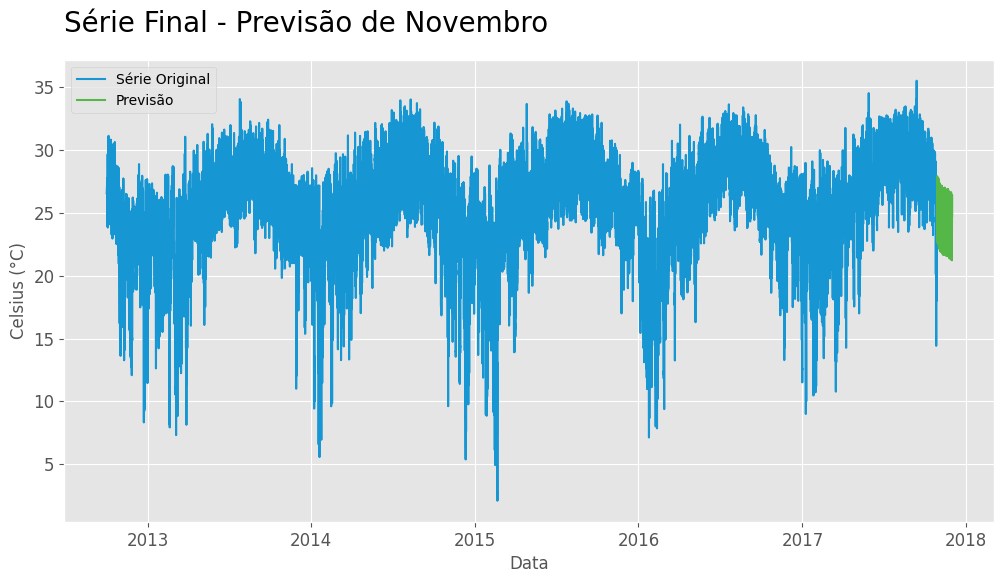

In [347]:
plt.title("Série Final - Previsão de Novembro", loc="left")
plt.plot(df_clean.celsius, color=CYAN)
plt.plot(df_pred_final, color=GREEN)
plt.xlabel("Data")
plt.ylabel("Celsius (°C)")
plt.legend(["Série Original", "Previsão"], loc="best")
plt.show()

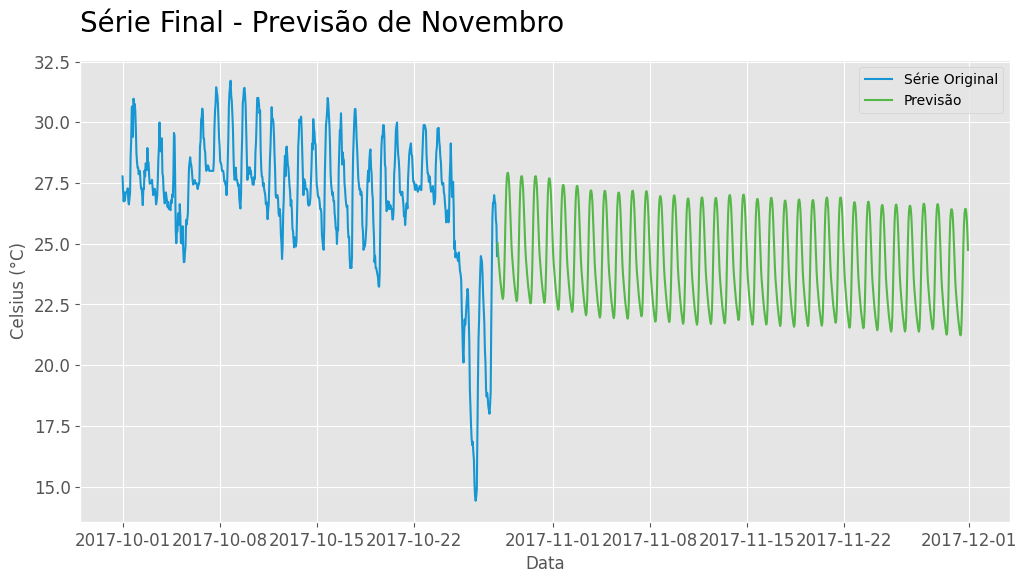

In [349]:
plt.title("Série Final - Previsão de Novembro", loc="left")
plt.plot(df_clean.celsius["2017-10":], color=CYAN)
plt.plot(df_pred_final, color=GREEN)
plt.xlabel("Data")
plt.ylabel("Celsius (°C)")
plt.legend(["Série Original", "Previsão"], loc="best")
plt.show()

#### Salvando Dados Previstos

In [353]:
df_pred_final.head()
df_pred_final.rename(columns={"yhat":"celsius"}, inplace=True)
df_pred_final["temperatura"] = df_pred_final.celsius + 273.15

In [354]:
df_pred_final.tail()

,celsius,temperatura
ds,,
2017-11-30 19:00:00,26.434522,299.584522
2017-11-30 20:00:00,26.295555,299.445555
2017-11-30 21:00:00,25.969278,299.119278
2017-11-30 22:00:00,25.430527,298.580527
2017-11-30 23:00:00,24.743485,297.893485


In [371]:
df_final = pd.concat([df_clean, df_pred_final])

In [375]:
df_final.index.name = "horario"
df_final.to_csv("temperatura_final.csv", index_label="horario")